# Automated Guided vehicles (AGV) PROJECT

## Loading the required modules

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d0c217345947f55f8f557b83ce21e44bbd152cae4ab2d3288d45e108d40ff5c7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
import lime
from lime import lime_tabular
from sklearn.tree import plot_tree

## Loading and preparing the data

In [ ]:
# Load the data
training_data = pd.read_excel('soc_delta_values jan feb Training.xlsx')
validation_data = pd.read_excel('soc_delta_values_nov_dec_validation.xlsx')

# Drop unnamed columns
unnamed_cols_train = [col for col in training_data.columns if 'Unnamed' in col]
unnamed_cols_valid = [col for col in validation_data.columns if 'Unnamed' in col]
training_data.drop(columns=unnamed_cols_train, inplace=True)
validation_data.drop(columns=unnamed_cols_valid, inplace=True)

# Convert timestamps to datetime
training_data['event_timestamp_EST'] = pd.to_datetime(training_data['event_timestamp_EST'])
validation_data['event_timestamp_est'] = pd.to_datetime(validation_data['event_timestamp_est'])
training_data['Fault_Tmestamp'] = pd.to_datetime(training_data['Fault_Tmestamp'])

# Check the data
print(training_data.head())
print(validation_data.head())


   Column1       Source.Name                 event_timestamp  soc carrierID  \
0        1  B0X002_Feb11.csv  2024-02-02 12:15:42.360000 UTC   34   BOX-002   
1        2  B0X002_Feb11.csv  2024-02-02 12:17:28.706000 UTC   37   BOX-002   
2        3  B0X002_Feb11.csv  2024-02-02 12:18:58.694000 UTC   81   BOX-002   
3        4  B0X002_Feb11.csv  2024-02-02 12:20:17.904000 UTC   85   BOX-002   
4        5  B0X002_Feb11.csv  2024-02-02 12:21:35.711000 UTC   73   BOX-002   

      event_timestamp_EST      Fault_Tmestamp              Combined_Column  \
0 2024-02-02 07:15:42.360 2024-02-11 13:30:27  BOX-002_2024-02-11 13:30:27   
1 2024-02-02 07:17:28.706 2024-02-11 13:30:27  BOX-002_2024-02-11 13:30:27   
2 2024-02-02 07:18:58.694 2024-02-11 13:30:27  BOX-002_2024-02-11 13:30:27   
3 2024-02-02 07:20:17.904 2024-02-11 13:30:27  BOX-002_2024-02-11 13:30:27   
4 2024-02-02 07:21:35.711 2024-02-11 13:30:27  BOX-002_2024-02-11 13:30:27   

   SOC_Drop_Per_Minute  Charging  Normal Operation  
0  

## EDA and Feature engineering

### EXploratory Data Analysis (EDA)

SOC Summary Statistics:
count    26291.000000
mean        72.248222
std         18.190439
min          0.000000
25%         63.000000
50%         76.000000
75%         85.000000
max        100.000000
Name: soc, dtype: float64


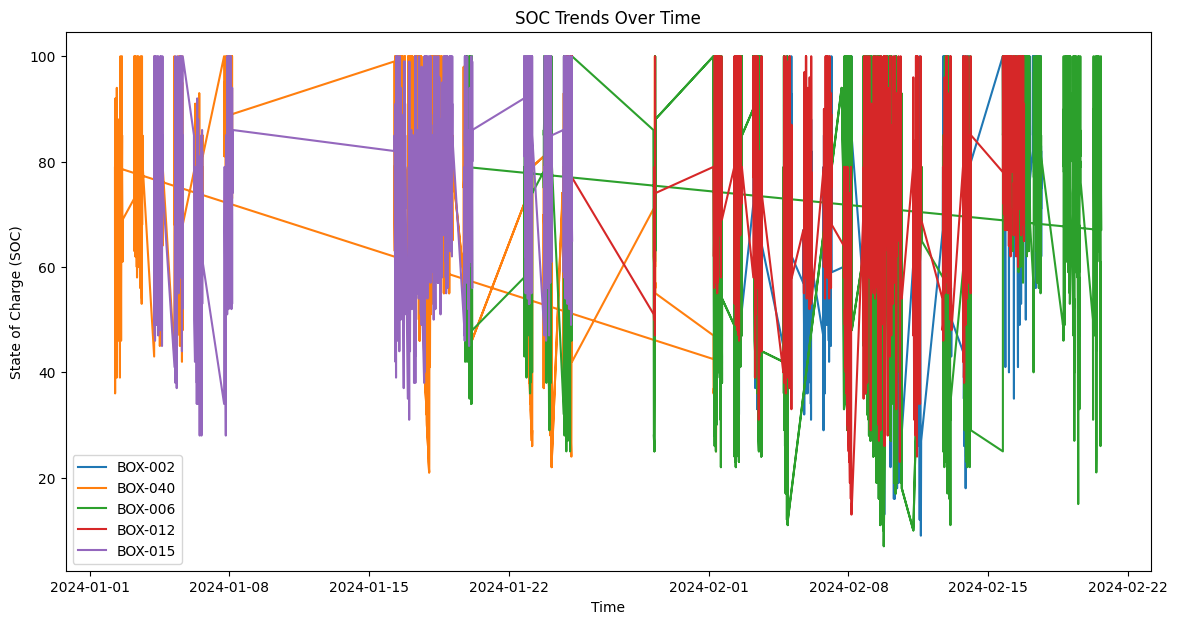

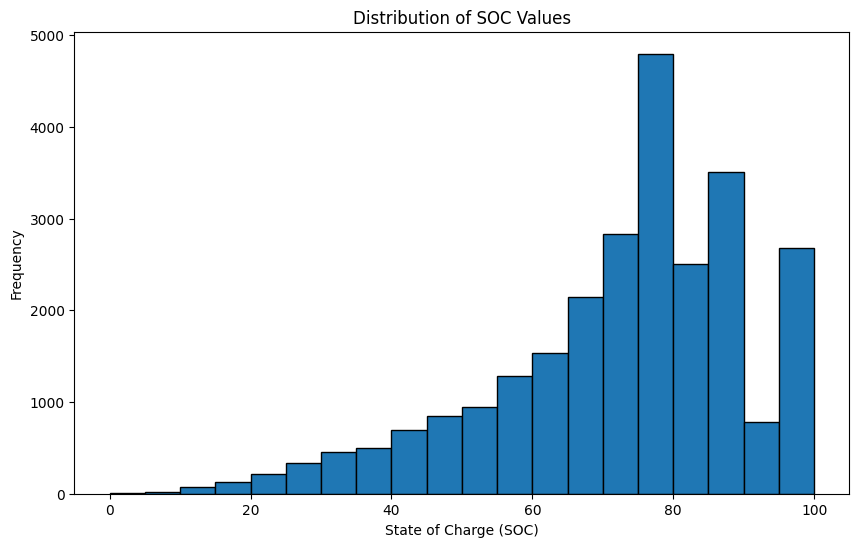

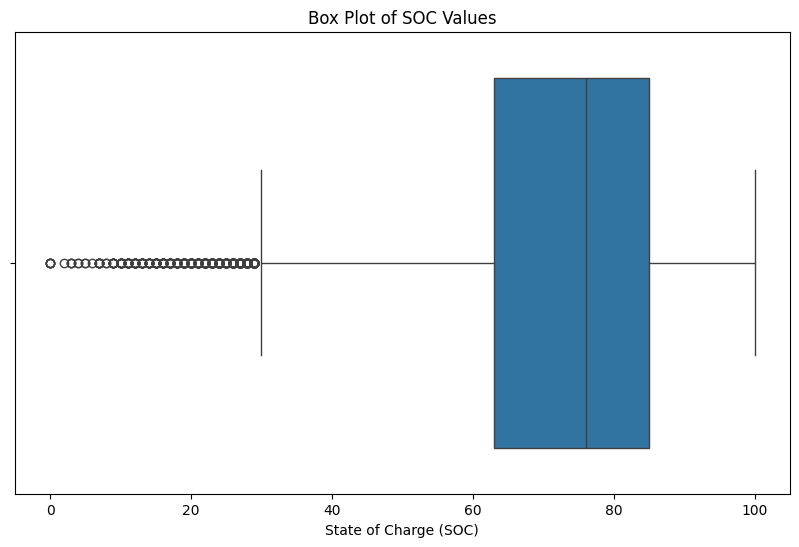

In [ ]:
# PLOT OF SOC DRPS(TRENDS) OVER TIME

# Summary Statistics
soc_stats = training_data['soc'].describe()
print("SOC Summary Statistics:")
print(soc_stats)

# SOC Trends Over Time Visualization (for a subset of batteries)
sample_ids = training_data['carrierID'].unique()[:5]  # A sample of unique carrier IDs
plt.figure(figsize=(14, 7))
for carrier_id in sample_ids:
    subset = training_data[training_data['carrierID'] == carrier_id]
    plt.plot(subset['event_timestamp_EST'], subset['soc'], label=carrier_id)
plt.title('SOC Trends Over Time')
plt.xlabel('Time')
plt.ylabel('State of Charge (SOC)')
plt.legend()
plt.show()

# Histogram of SOC Values
plt.figure(figsize=(10, 6))
plt.hist(training_data['soc'], bins=20, edgecolor='black')
plt.title('Distribution of SOC Values')
plt.xlabel('State of Charge (SOC)')
plt.ylabel('Frequency')
plt.show()

# Boxplot of SOC Values
plt.figure(figsize=(10, 6))
sns.boxplot(x=training_data['soc'])
plt.title('Box Plot of SOC Values')
plt.xlabel('State of Charge (SOC)')
plt.show()


### Feature Engineering

In [ ]:
# Calculating Rate of SOC Change by carrier ID
training_data['SOC_Change'] = training_data.groupby('carrierID')['soc'].diff().fillna(0)

# Rolling Statistics: Rolling Average and Standard Deviation
rolling_window = 24  # Assuming hourly data ovr 24 hours
training_data['Rolling_Avg_SOC'] = training_data.groupby('carrierID')['soc'].rolling(window=rolling_window).mean().reset_index(level=0, drop=True)
training_data['Rolling_Std_SOC'] = training_data.groupby('carrierID')['soc'].rolling(window=rolling_window).std().reset_index(level=0, drop=True)

# Calculating Time to Event: Days until failure (Using the Fault_Timestamp column)
# Assuming 'Fault_Tmestamp' is the column that contains the timestamp of failure events
training_data['Time_To_Event'] = (training_data['Fault_Tmestamp'] - training_data['event_timestamp_EST']).dt.total_seconds() / (24 * 3600)
training_data['Time_To_Event'] = training_data['Time_To_Event'].fillna(max(training_data['Time_To_Event']))


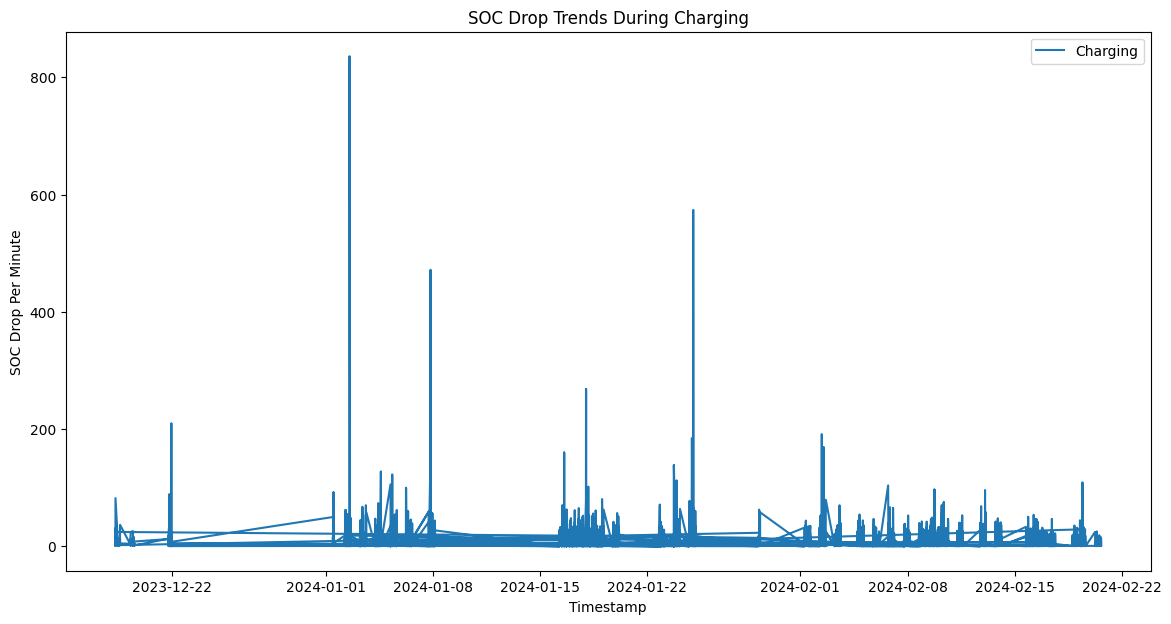

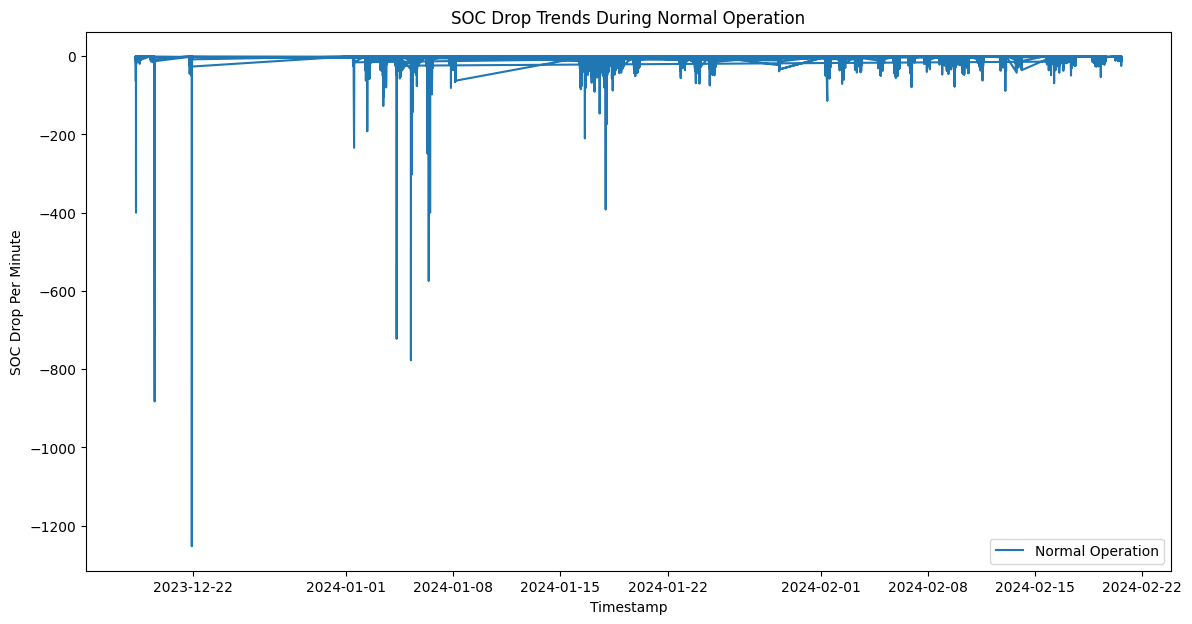

In [ ]:
# Analyzing SOC Drop Trends using only the data leading up to failure events.
# Major Assumptions:'Fault_Tmestamp' marks the failure event timestamp and that the SOC drop during charging and normal operation are important.

# Converting timestamp columns to datetime format
training_data['event_timestamp_EST'] = pd.to_datetime(training_data['event_timestamp_EST'])
training_data['Fault_Tmestamp'] = pd.to_datetime(training_data['Fault_Tmestamp'])

# Filtering out data points that have no associated failure event timestamp.
data_with_failures = training_data.dropna(subset=['Fault_Tmestamp'])

# Calculating the number of days to the failure event for each data point.
data_with_failures['Days_To_Failure'] = (data_with_failures['Fault_Tmestamp'] - data_with_failures['event_timestamp_EST']).dt.days


# Analysing SOC trends separately for charging and normal operation.
charging_data = data_with_failures[data_with_failures['Charging'] == 1]
normal_operation_data = data_with_failures[data_with_failures['Normal Operation'] == 1]

# Copy of the data
data = training_data.copy()

# Separation : Charging and normal operation
charging_data = data[data['Charging'] == 1]
normal_operation_data = data[data['Normal Operation'] == 1]

# Plot of SOC Drop Trends for Charging
plt.figure(figsize=(14, 7))
plt.plot(charging_data['event_timestamp_EST'], charging_data['SOC_Drop_Per_Minute'], label='Charging')
plt.title('SOC Drop Trends During Charging')
plt.xlabel('Timestamp')
plt.ylabel('SOC Drop Per Minute')
plt.legend()
plt.show()

# Plot of SOC Drop Trends for Normal Operation
plt.figure(figsize=(14, 7))
plt.plot(normal_operation_data['event_timestamp_EST'], normal_operation_data['SOC_Drop_Per_Minute'], label='Normal Operation')
plt.title('SOC Drop Trends During Normal Operation')
plt.xlabel('Timestamp')
plt.ylabel('SOC Drop Per Minute')
plt.legend()
plt.show()


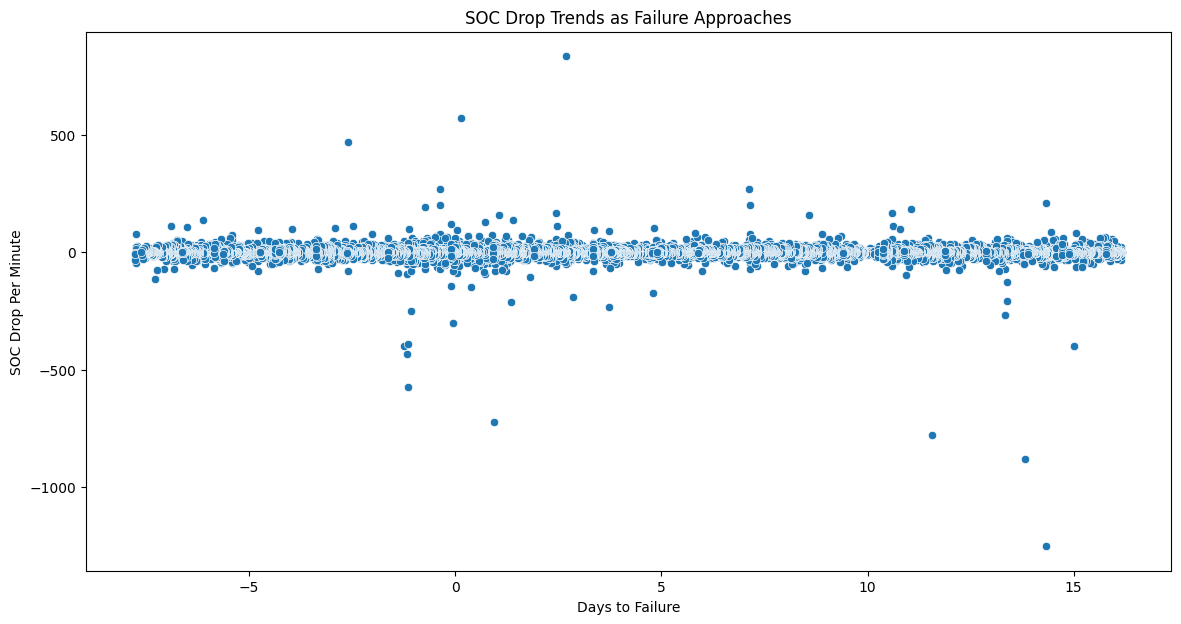

<ipython-input-8-9d8a48d27dc3>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Days_To_Failure', y='Rolling_SOC_Drop', data=data, ci=None)


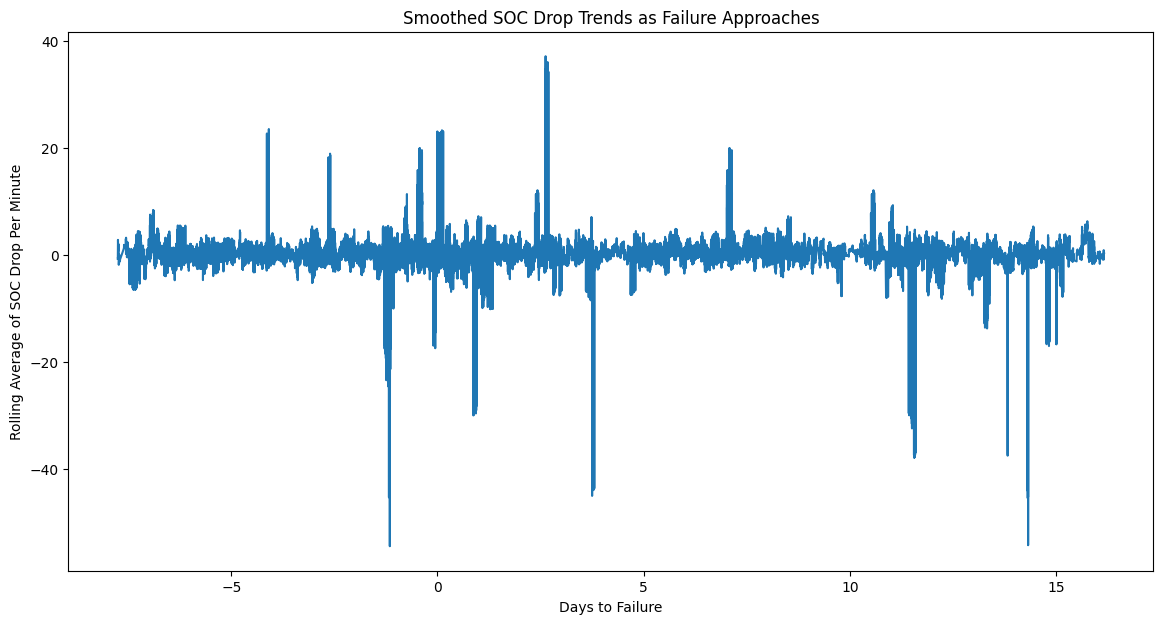

In [ ]:
# Calculating SOC drop trends as battery failure approaches

# Datetime Conversions
data['event_timestamp_EST'] = pd.to_datetime(data['event_timestamp_EST'])
data['Fault_Tmestamp'] = pd.to_datetime(data['Fault_Tmestamp'])

# Number of days to the nearest failure event for each record
data['Days_To_Failure'] = (data['Fault_Tmestamp'] - data['event_timestamp_EST']).dt.total_seconds() / (24 * 3600)

# Scatter plot of SOC_Drop_Per_Minute against Days_To_Failure
plt.figure(figsize=(14, 7))
sns.scatterplot(x='Days_To_Failure', y='SOC_Drop_Per_Minute', data=data)
plt.title('SOC Drop Trends as Failure Approaches')
plt.xlabel('Days to Failure')
plt.ylabel('SOC Drop Per Minute')
plt.show()

# Plot a little noisy : using a lineplot with a rolling average to smooth it out
data['Rolling_SOC_Drop'] = data.groupby('carrierID')['SOC_Drop_Per_Minute'].rolling(window=24).mean().reset_index(level=0, drop=True)
plt.figure(figsize=(14, 7))
sns.lineplot(x='Days_To_Failure', y='Rolling_SOC_Drop', data=data, ci=None)
plt.title('Smoothed SOC Drop Trends as Failure Approaches')
plt.xlabel('Days to Failure')
plt.ylabel('Rolling Average of SOC Drop Per Minute')
plt.show()


In [ ]:
# Attempting to find the correlating between SOC drop trends per minute with days to failure for both charging and normal op conditions

# SOC drop per minute for both conditions
charging_data = data[data['Charging'] == 1].copy()
normal_operation_data = data[data['Normal Operation'] == 1].copy()

# SOC drop per minute for charging data
charging_data['SOC_Drop_Per_Minute'] = charging_data.groupby('carrierID')['soc'].diff() / \
                                       charging_data.groupby('carrierID')['event_timestamp_EST'].diff().dt.total_seconds() * 60

# Calculate SOC drop per minute for normal operation data
normal_operation_data['SOC_Drop_Per_Minute'] = normal_operation_data.groupby('carrierID')['soc'].diff() / \
                                               normal_operation_data.groupby('carrierID')['event_timestamp_EST'].diff().dt.total_seconds() * 60

# Dropping NaN values resulting from the diff operation
charging_data = charging_data.dropna(subset=['SOC_Drop_Per_Minute', 'Days_To_Failure'])
normal_operation_data = normal_operation_data.dropna(subset=['SOC_Drop_Per_Minute', 'Days_To_Failure'])

# Correlation between SOC drop per minute and days to failure for charging data
charging_correlation = charging_data['SOC_Drop_Per_Minute'].corr(charging_data['Days_To_Failure'])
print(f"Correlation of SOC drop per minute with days to failure during charging: {charging_correlation}")

# Correlation between SOC drop per minute and days to failure for normal operation data
normal_operation_correlation = normal_operation_data['SOC_Drop_Per_Minute'].corr(normal_operation_data['Days_To_Failure'])
print(f"Correlation of SOC drop per minute with days to failure during normal operation: {normal_operation_correlation}")


Correlation of SOC drop per minute with days to failure during charging: -0.0016912577669183232
Correlation of SOC drop per minute with days to failure during normal operation: -0.010529730371197542


    Charging_Avg_SOC_Drop  Normal_Op_Avg_SOC_Drop
1                1.590937               -0.961260
2                1.381474               -1.336489
3                1.774344               -0.933306
4                1.837154               -0.991929
5                1.418147               -0.979357
6                1.374028               -0.872268
7                1.682237               -0.589846
8                2.014402               -0.388988
9                1.451600               -0.844080
10               1.429989               -1.035809
11               1.429693               -1.196103
12               1.476471               -2.259537
13               1.083401               -0.999861
14               1.415142               -1.712867
15               1.538498               -0.986134


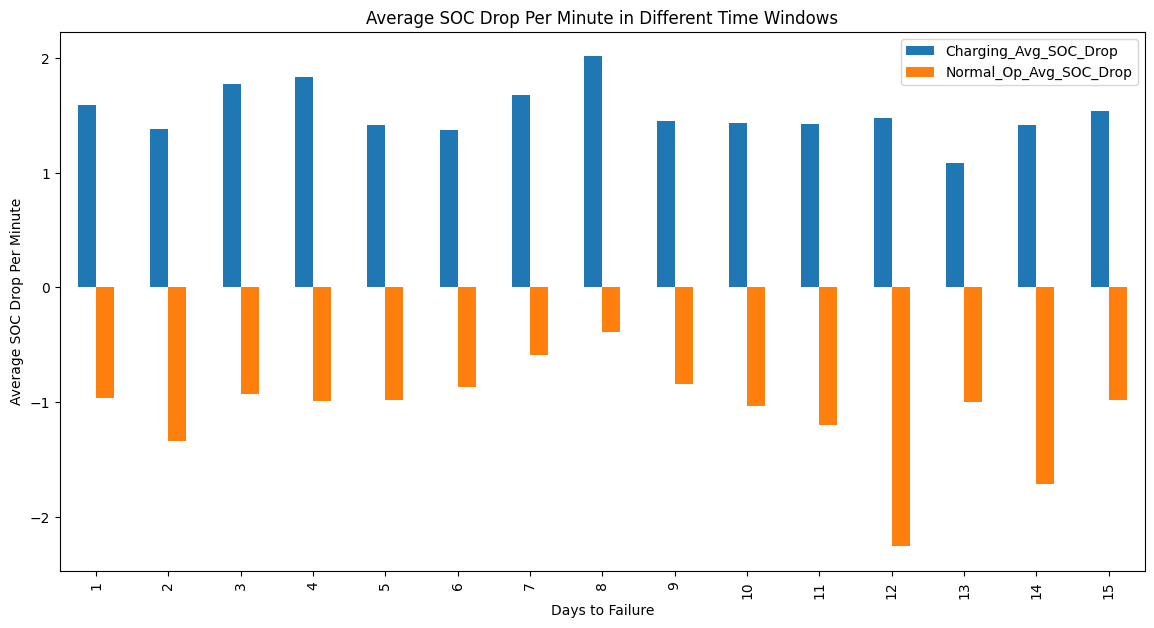

In [ ]:
#TIME WINDOW ANALYSIS

# Initializing the DataFrame to store the averages
time_window_analysis = pd.DataFrame(columns=['Charging_Avg_SOC_Drop', 'Normal_Op_Avg_SOC_Drop'])

# Calculating the averages for each window
for window in range(1, 16):  # 1 to 15 days
    # Mask for the charging data within the current window
    charging_mask = (charging_data['Days_To_Failure'] < window) & (charging_data['Days_To_Failure'] >= window-1)
    # Average SOC drop per minute for the current window
    charging_avg = charging_data.loc[charging_mask, 'SOC_Drop_Per_Minute'].mean()

    # Same thing for the normal operation data
    normal_op_mask = (normal_operation_data['Days_To_Failure'] < window) & (normal_operation_data['Days_To_Failure'] >= window-1)
    normal_op_avg = normal_operation_data.loc[normal_op_mask, 'SOC_Drop_Per_Minute'].mean()

    # Assigning the calculated averages to the time_window_analysis DataFrame
    time_window_analysis.loc[window] = [charging_avg, normal_op_avg]

print(time_window_analysis)

# Plotting the averages
time_window_analysis.plot(kind='bar', figsize=(14, 7))
plt.title('Average SOC Drop Per Minute in Different Time Windows')
plt.xlabel('Days to Failure')
plt.ylabel('Average SOC Drop Per Minute')
plt.show()


   CarrierID  Days_To_Failure  Charging_Avg_SOC_Drop  Normal_Op_Avg_SOC_Drop
0    BOX-012                1               5.516481               -5.477721
1    BOX-012                2               4.752114               -3.972022
2    BOX-012                3               5.468083               -4.150418
3    BOX-012                4               7.636547               -7.803917
4    BOX-012                5               9.097539               -6.280024
5    BOX-012                6               0.793575               -1.439749
6    BOX-012                7               7.793920               -5.527177
7    BOX-012                8               6.219131               -5.775694
8    BOX-012                9               5.566026               -4.807228
9    BOX-012               12              12.434746               -5.682488
10   BOX-012               16              12.862473               -6.318093


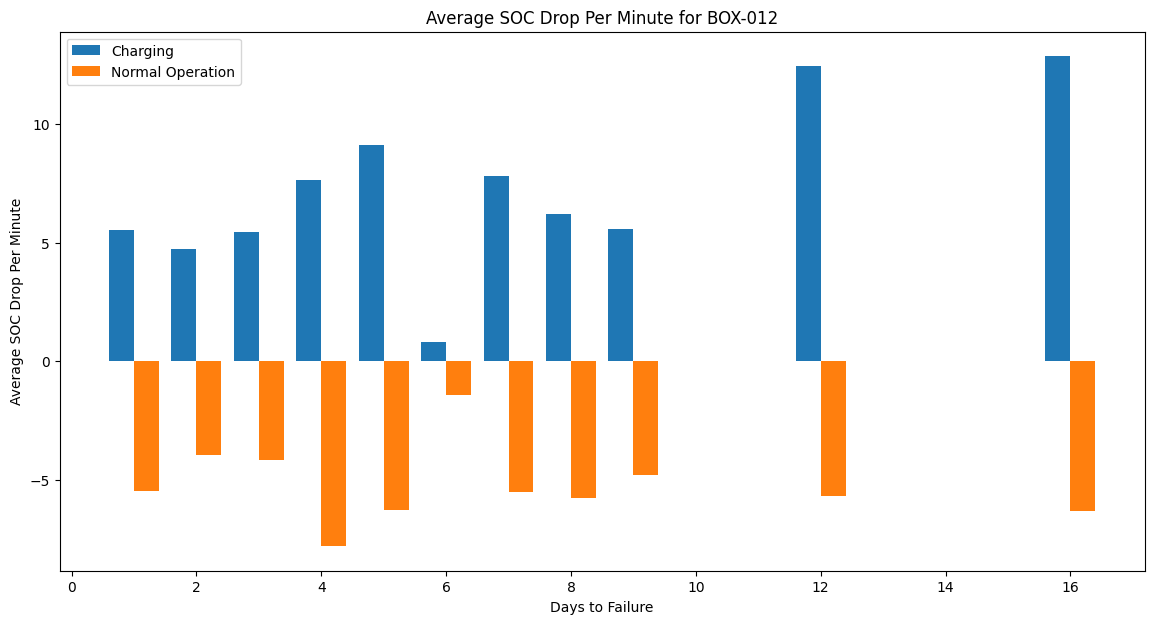

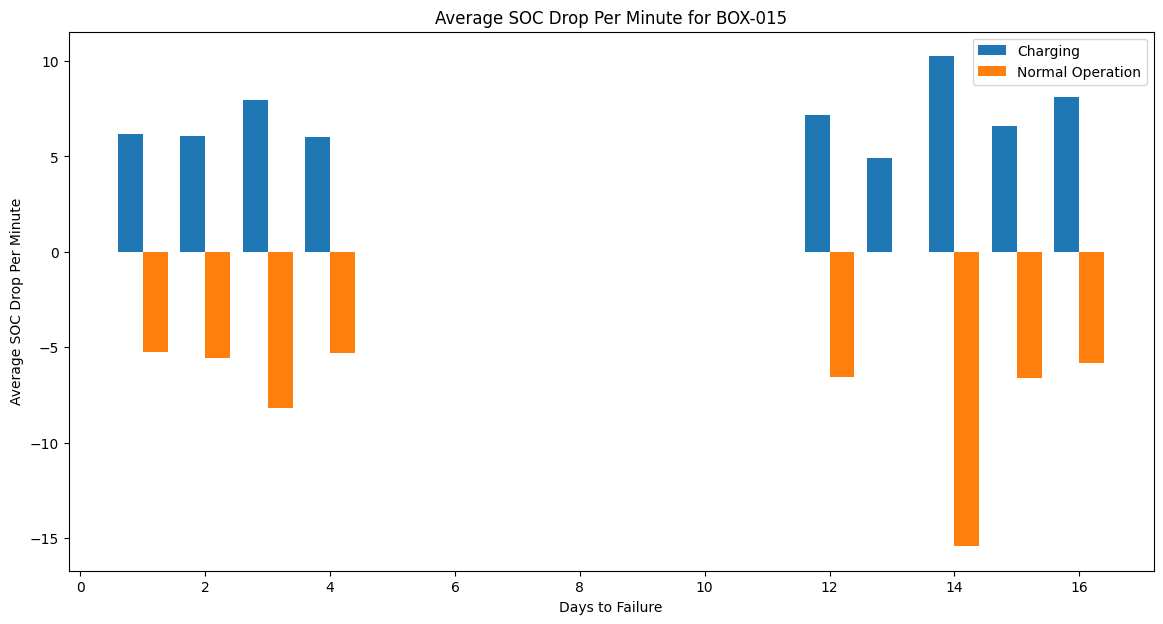

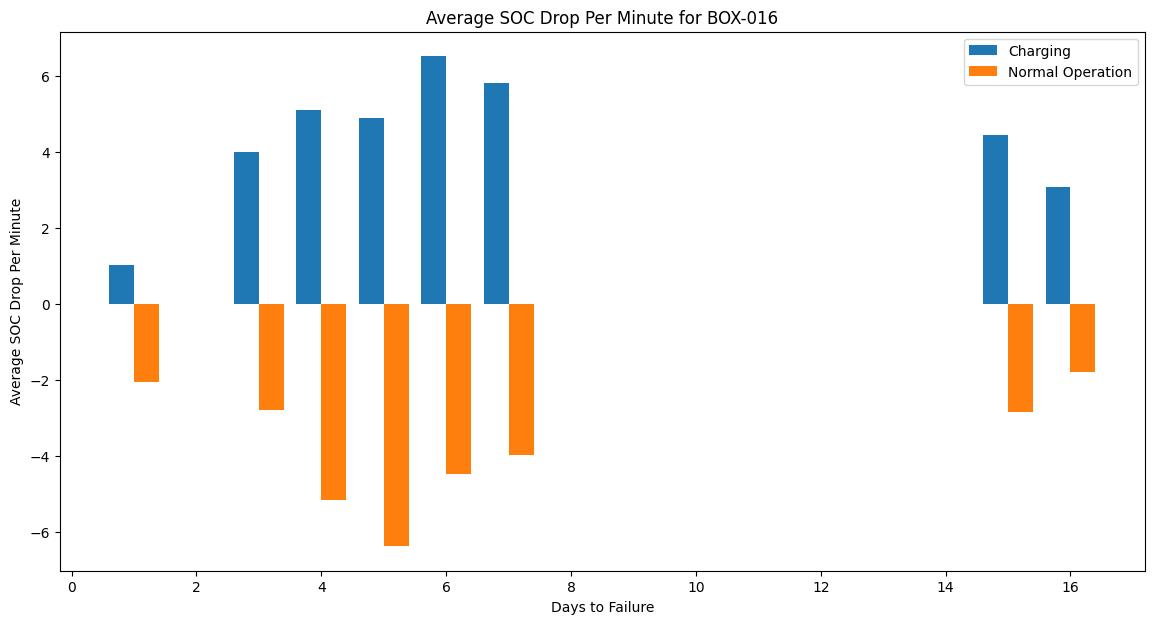

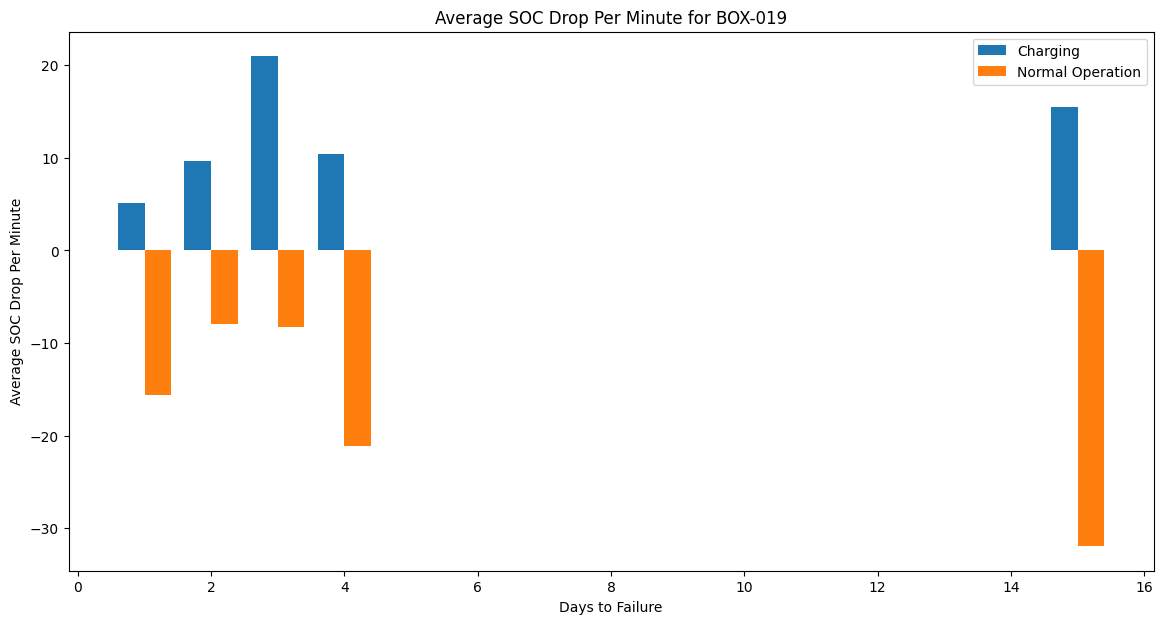

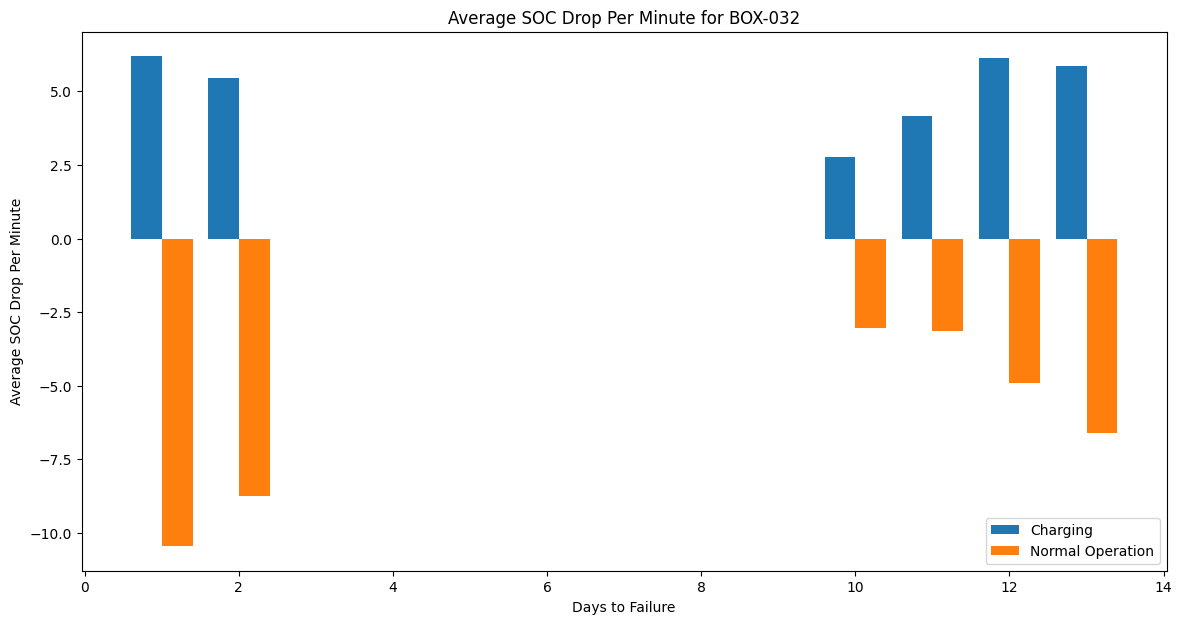

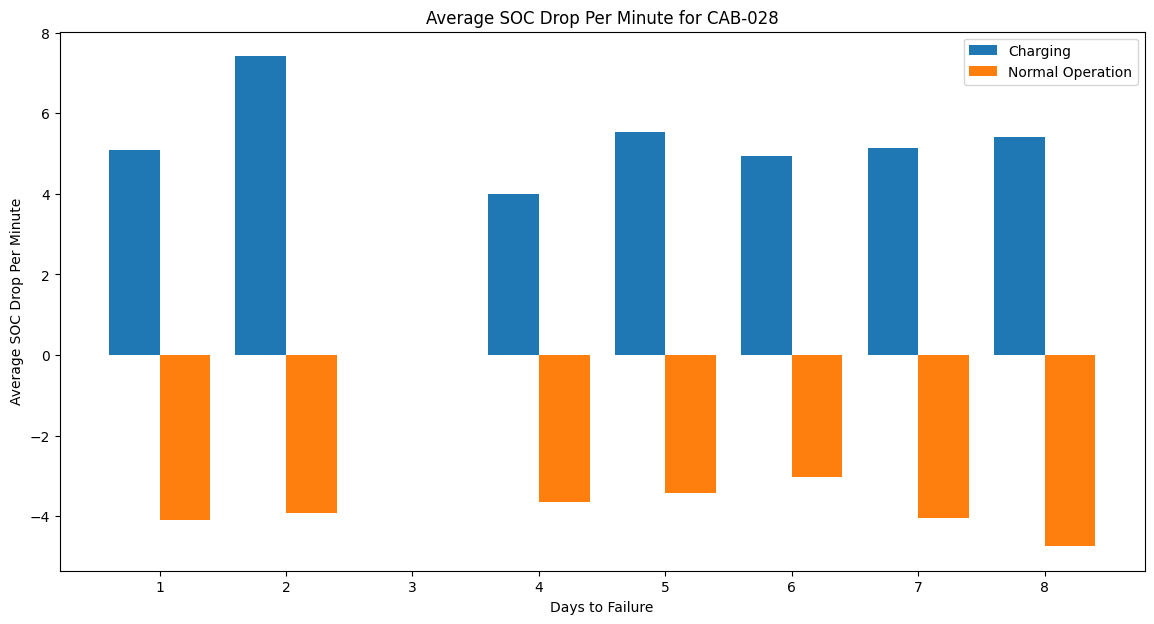

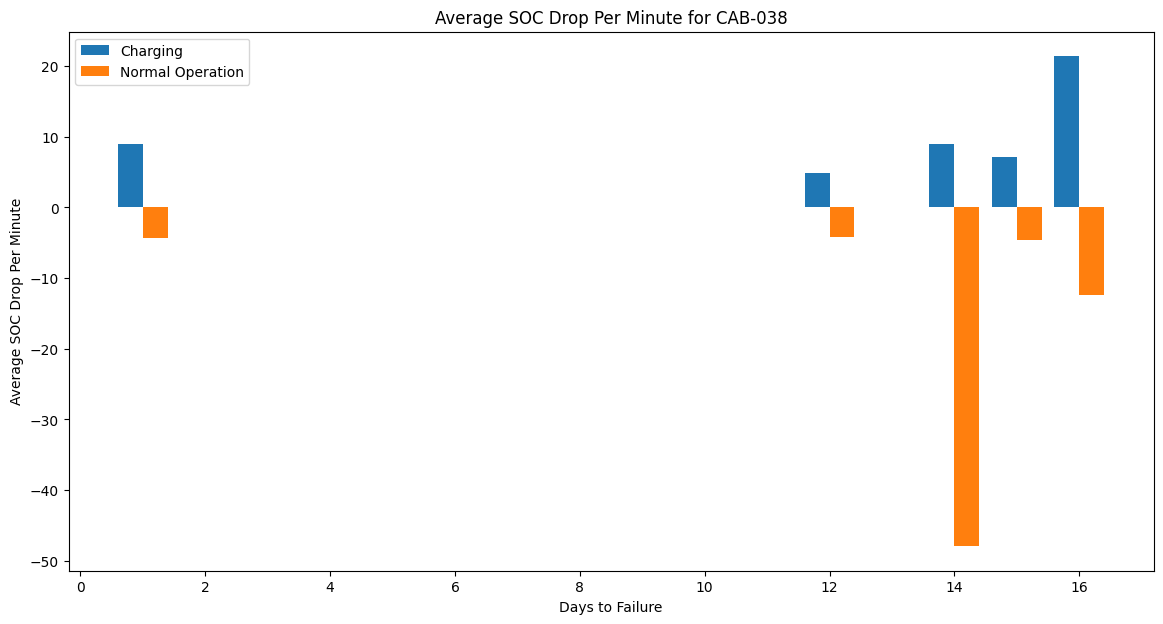

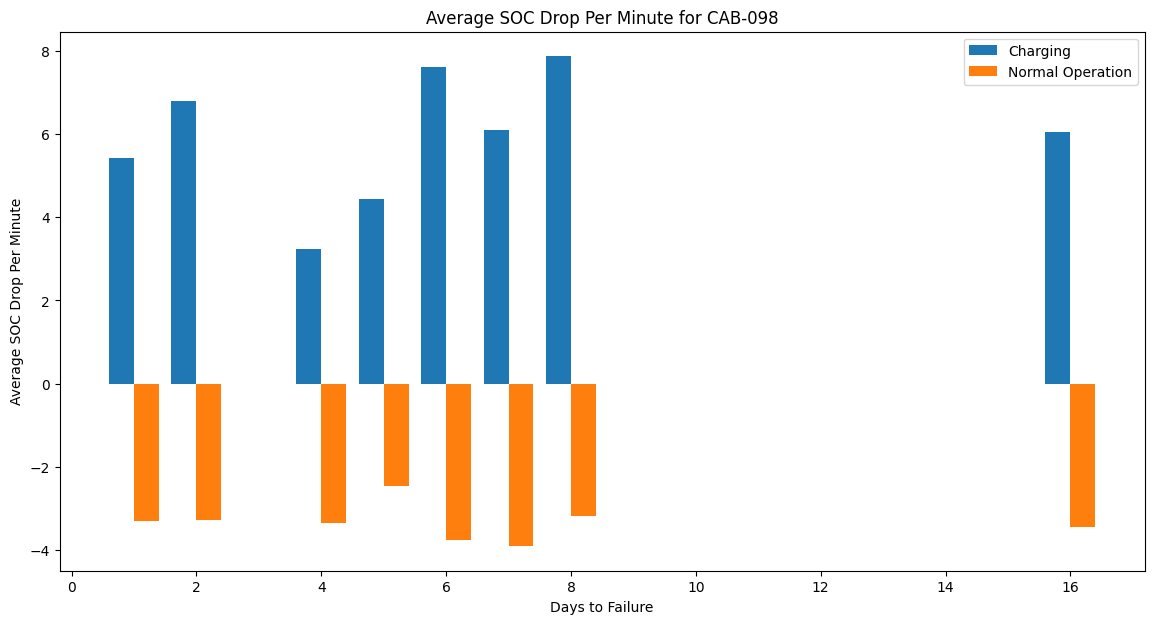

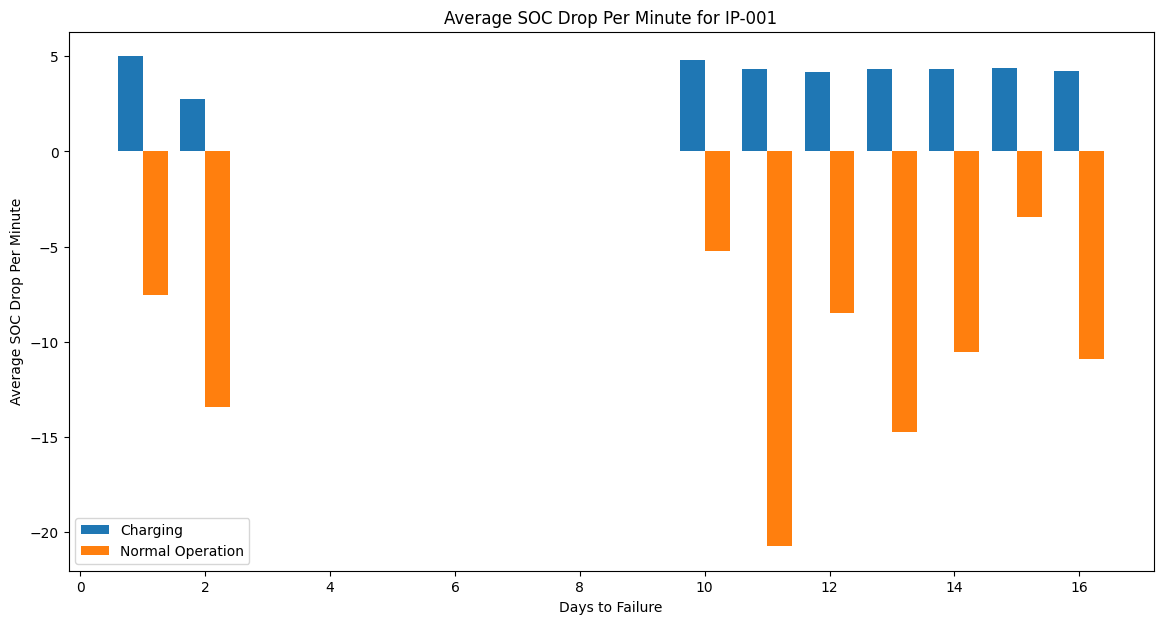

In [ ]:
# Making a comparison to the soc trends of "good" units

import pandas as pd
import matplotlib.pyplot as plt

# Loading a copy of our main data
training_data2 = data.copy()

# Carrier IDs of interest
carrier_ids = ['BOX-012', 'BOX-015', 'BOX-016', 'BOX-019', 'BOX-032',
               'CAB-028', 'CAB-038', 'CAB-098', 'IP-001']

# List to collect DataFrame slices
time_window_analysis_list = []

# Time window analysis for these specific carrier IDs
for carrier_id in carrier_ids:
    for window in range(1, 17):  # 1 to 15 days
        # Filter data for the specific carrier ID and window
        carrier_data = training_data[(training_data2['carrierID'] == carrier_id) &
                                     (training_data2['Days_To_Failure'] < window) &
                                     (training_data2['Days_To_Failure'] >= window-1)]

        # Checking if carrier_data is empty
        if carrier_data.empty:
            continue

        # Average SOC drop per minute for charging and normal operation
        charging_avg = carrier_data[carrier_data['Charging'] == 1]['SOC_Drop_Per_Minute'].mean()
        normal_op_avg = carrier_data[carrier_data['Normal Operation'] == 1]['SOC_Drop_Per_Minute'].mean()

        # Append the averages to the list as a DataFrame
        time_window_analysis_list.append(pd.DataFrame({
            'CarrierID': [carrier_id],
            'Days_To_Failure': [window],
            'Charging_Avg_SOC_Drop': [charging_avg],
            'Normal_Op_Avg_SOC_Drop': [normal_op_avg]
        }))

# Concatenating DataFrame slices in the list to create the final DataFrame
specific_time_window_analysis = pd.concat(time_window_analysis_list, ignore_index=True)

# Example results
print(specific_time_window_analysis[specific_time_window_analysis['CarrierID'] == 'BOX-012'])

# Plotting the results for each carrier ID separately
for carrier_id in carrier_ids:
    carrier_data = specific_time_window_analysis[specific_time_window_analysis['CarrierID'] == carrier_id]
    plt.figure(figsize=(14, 7))
    plt.bar(carrier_data['Days_To_Failure'] - 0.2, carrier_data['Charging_Avg_SOC_Drop'], width=0.4, label='Charging')
    plt.bar(carrier_data['Days_To_Failure'] + 0.2, carrier_data['Normal_Op_Avg_SOC_Drop'], width=0.4, label='Normal Operation')
    plt.title(f'Average SOC Drop Per Minute for {carrier_id}')
    plt.xlabel('Days to Failure')
    plt.ylabel('Average SOC Drop Per Minute')
    plt.legend()
    plt.show()

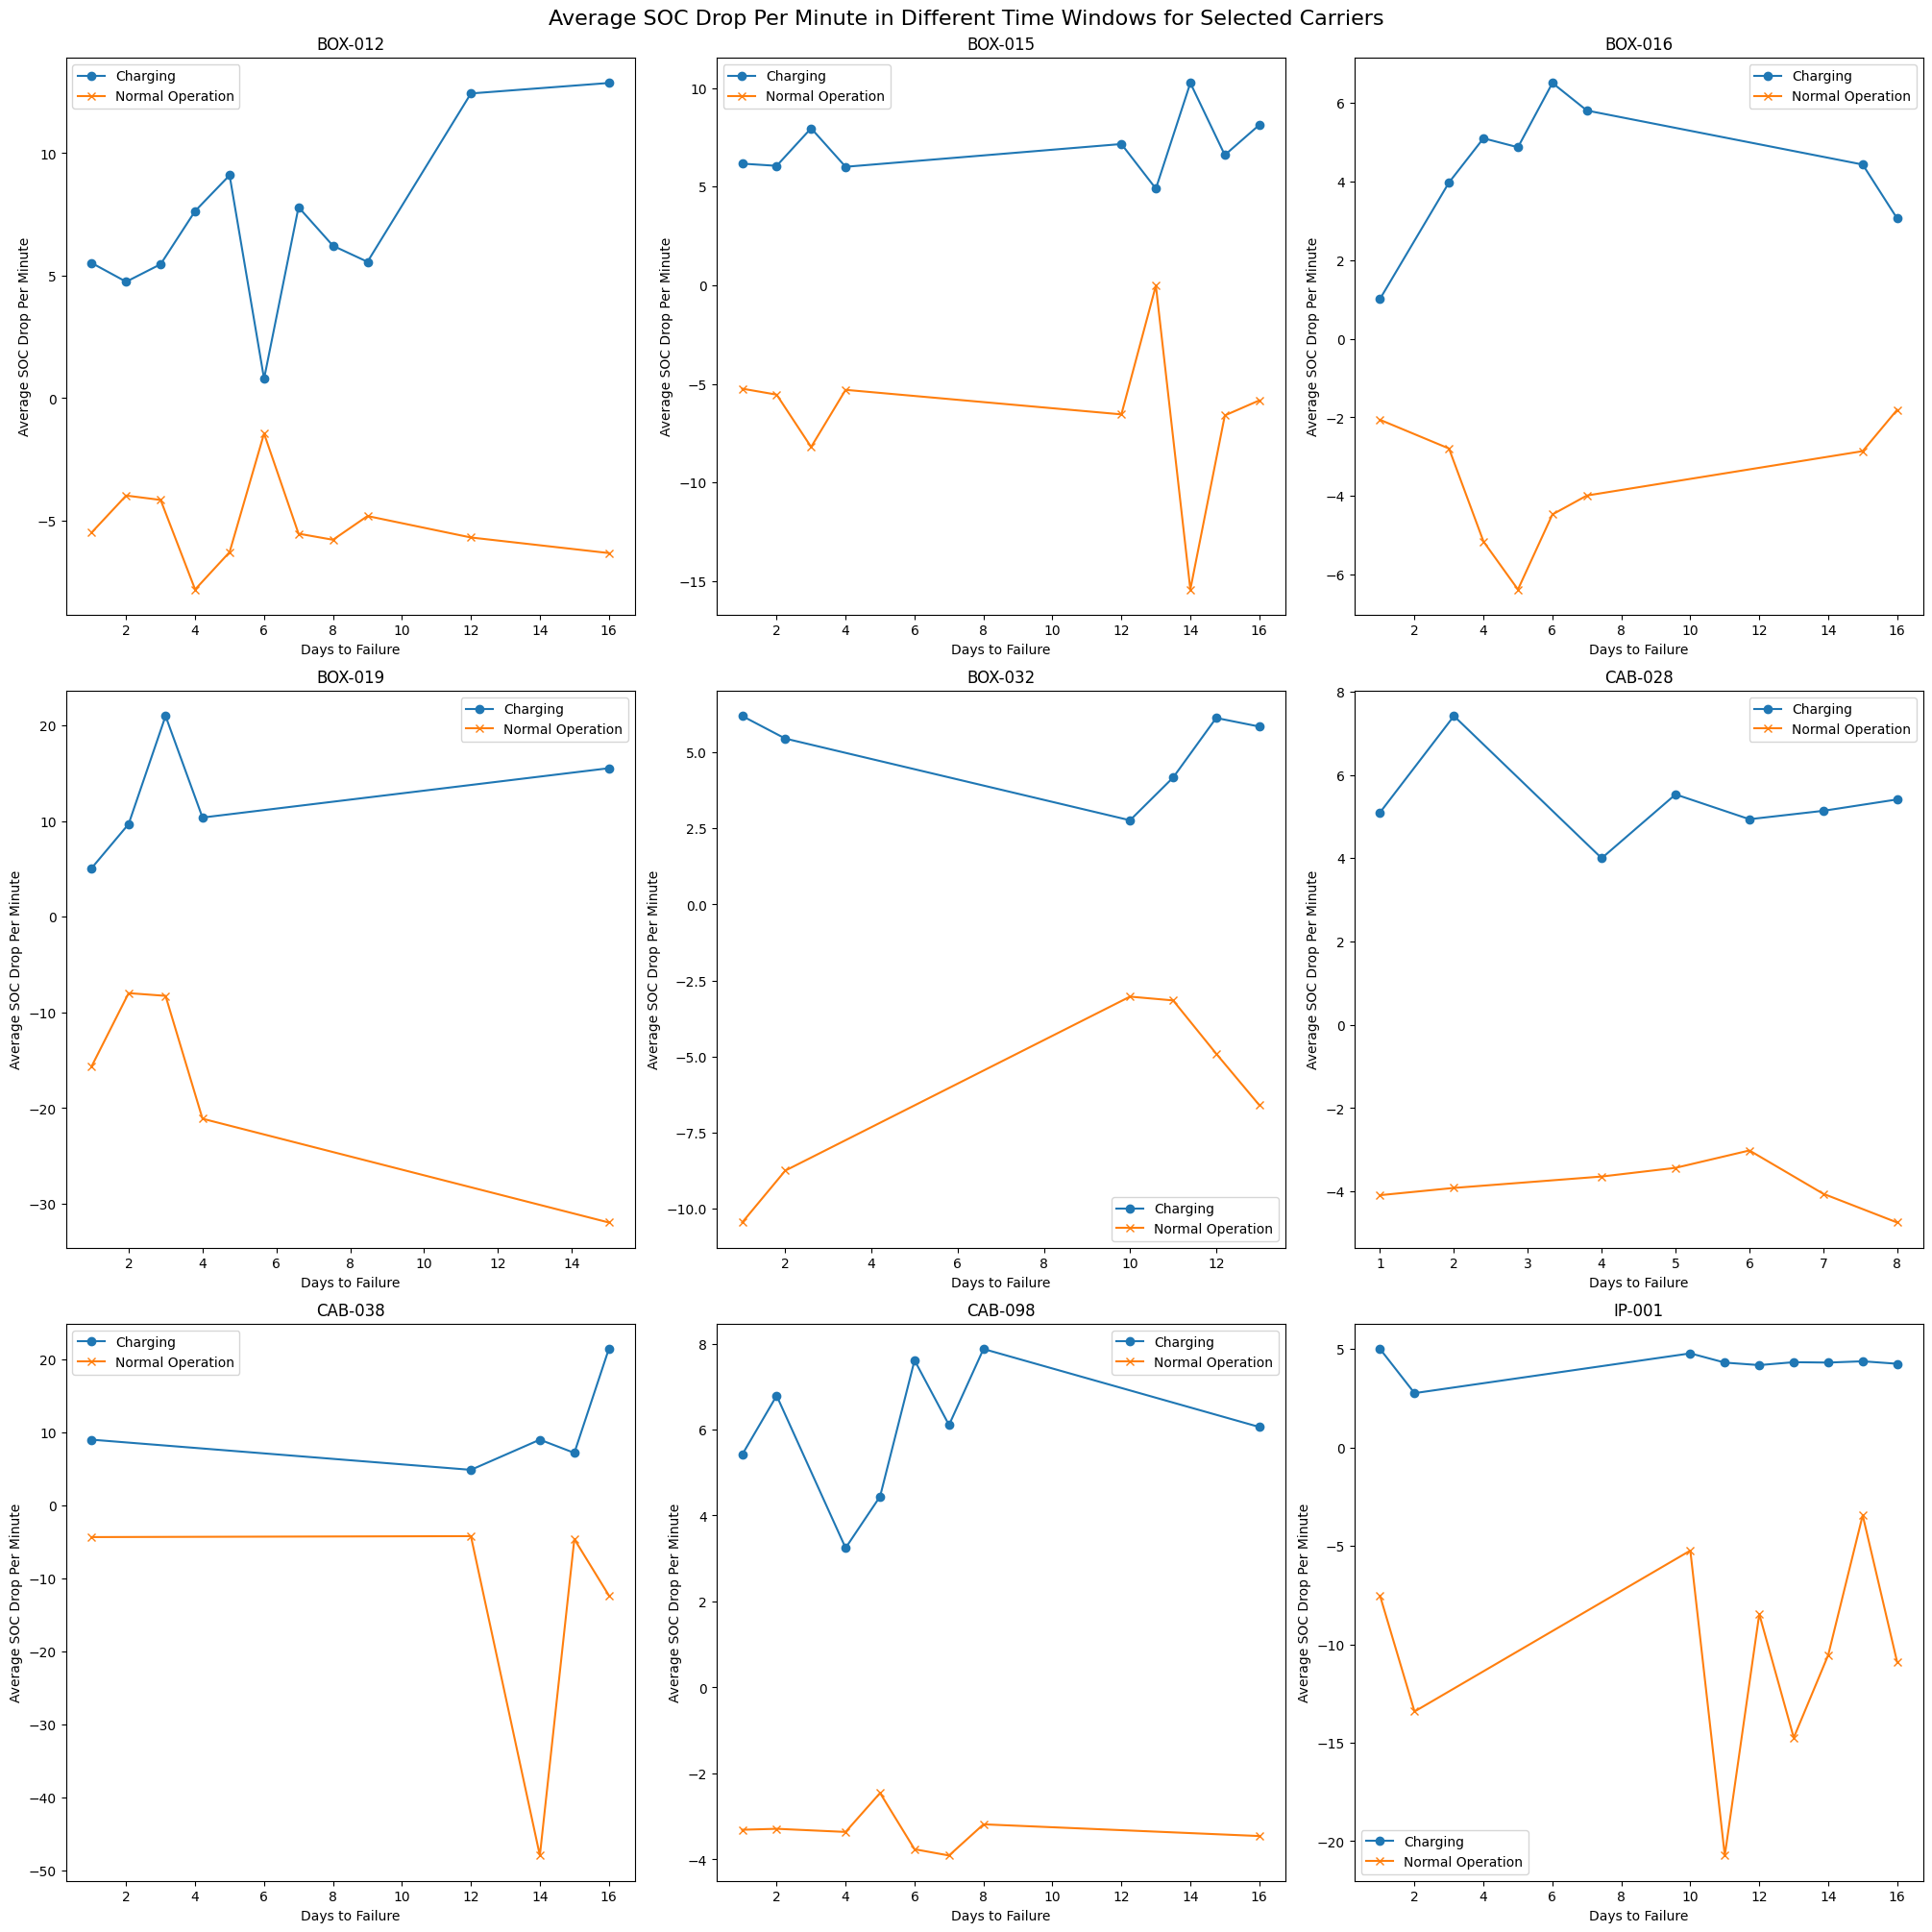

In [ ]:
# Viewing the results in a grid for comparison purposes
# rows and columns for the subplot grid
num_carriers = len(carrier_ids)
grid_size = int(num_carriers ** 0.5) + (1 if num_carriers % (num_carriers ** 0.5) > 0 else 0)

# Creating a figure and a set of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), constrained_layout=True)
fig.suptitle('Average SOC Drop Per Minute in Different Time Windows for Selected Carriers', fontsize=16)

# Flattening the axes array for easy indexing
axes = axes.flatten()

# Each carrier's average SOC drop per minute in its own subplot
for i, carrier_id in enumerate(carrier_ids):
    carrier_data = specific_time_window_analysis[specific_time_window_analysis['CarrierID'] == carrier_id]
    axes[i].plot(carrier_data['Days_To_Failure'], carrier_data['Charging_Avg_SOC_Drop'], marker='o', label='Charging')
    axes[i].plot(carrier_data['Days_To_Failure'], carrier_data['Normal_Op_Avg_SOC_Drop'], marker='x', label='Normal Operation')
    axes[i].set_title(carrier_id)
    axes[i].set_xlabel('Days to Failure')
    axes[i].set_ylabel('Average SOC Drop Per Minute')
    axes[i].legend()

# Hiding unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot grid
plt.show()

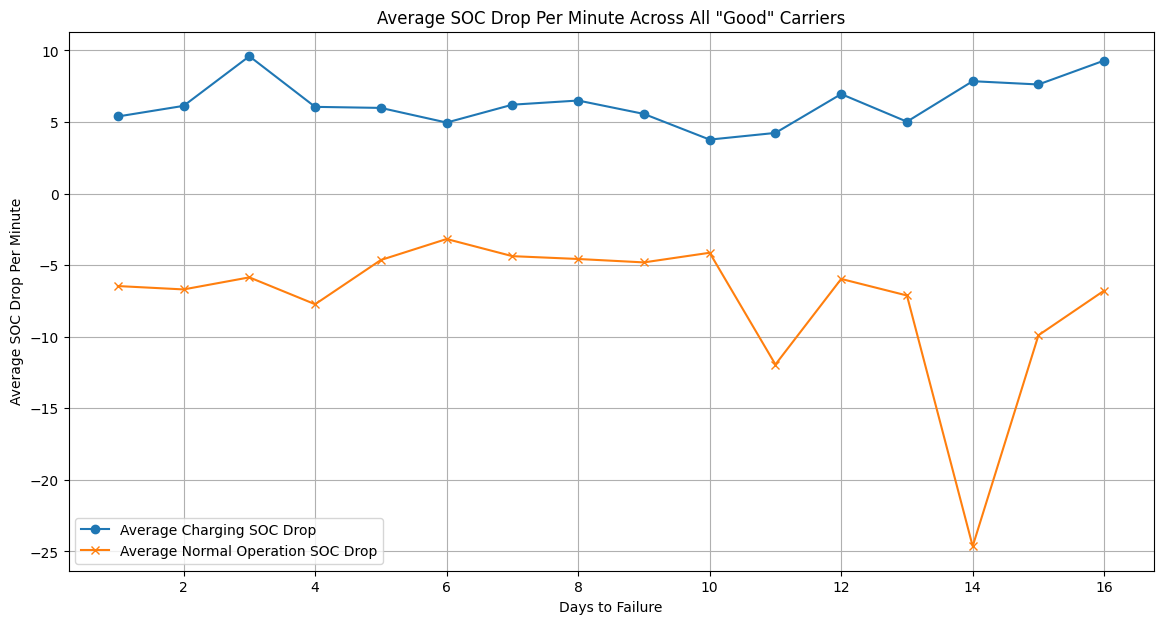

In [ ]:
# Average SOC drops for each day window across all carriers (Charging vs non-charging)
averages = specific_time_window_analysis.groupby('Days_To_Failure')[['Charging_Avg_SOC_Drop', 'Normal_Op_Avg_SOC_Drop']].mean()

# Creating the plot
plt.figure(figsize=(14, 7))
plt.plot(averages.index, averages['Charging_Avg_SOC_Drop'], marker='o', label='Average Charging SOC Drop')
plt.plot(averages.index, averages['Normal_Op_Avg_SOC_Drop'], marker='x', label='Average Normal Operation SOC Drop')

plt.title('Average SOC Drop Per Minute Across All "Good" Carriers')
plt.xlabel('Days to Failure')
plt.ylabel('Average SOC Drop Per Minute')
plt.legend()
plt.grid(True)
plt.show()


The plot shows the average SOC drop per minute across all selected "good" carriers as they approach the date of battery failure.

Interpretation:
- The blue line representing the average SOC drop during charging fluctuates above and below zero but remains mostly positive. This is expected since, during charging, the SOC should generally increase, though temporary drops may occur due to operational factors.

- The orange line for average SOC drop during normal operation is predominantly negative, which makes sense as the battery is being used and SOC decreases. Notably, there is a significant drop around 8 days before failure, followed by a recovery.

- There doesn’t appear to be a clear trend of increasing SOC drop as the battery approaches the failure date, but there are noticeable fluctuations, especially in normal operation conditions.

This plot suggests that the SOC drop per minute is not a straightforward indicator of impending failure. The lack of a clear trend towards failure could indicate that while SOC drop is an important feature, it needs to be considered alongside other indicators for a more reliable prediction of battery health and failure.

The goal still remains to identify a combination of features that can robustly predict battery failure.

## Feature selection for predictive model

In [ ]:
# Creating cyclical features in case of possible time based patterns

# Reloading the main DataFrame
data['event_timestamp_EST'] = pd.to_datetime(data['event_timestamp_EST'])

# Calculating the cyclical time features
data['Minute'] = data['event_timestamp_EST'].dt.minute
data['Hour'] = data['event_timestamp_EST'].dt.hour
data['Day'] = data['event_timestamp_EST'].dt.day
data['Weekday'] = data['event_timestamp_EST'].dt.weekday  # Monday=0, Sunday=6

minutes_in_day = 24 * 60
hours_in_day = 24
days_in_week = 7

data['Minute sin'] = np.sin(data['Minute'] * (2 * np.pi / minutes_in_day))
data['Minute cos'] = np.cos(data['Minute'] * (2 * np.pi / minutes_in_day))
data['Hour sin'] = np.sin(data['Hour'] * (2 * np.pi / hours_in_day))
data['Hour cos'] = np.cos(data['Hour'] * (2 * np.pi / hours_in_day))
data['Day sin'] = np.sin(data['Day'] * (2 * np.pi / data['Day'].max()))
data['Day cos'] = np.cos(data['Day'] * (2 * np.pi / data['Day'].max()))
data['Weekday sin'] = np.sin(data['Weekday'] * (2 * np.pi / days_in_week))
data['Weekday cos'] = np.cos(data['Weekday'] * (2 * np.pi / days_in_week))


       Column1  soc  SOC_Drop_Per_Minute  Charging  Normal Operation  \
0            1   34            -2.405965         0                 1   
1            2   37             1.692588         1                 0   
2            3   81            29.337245         1                 0   
3            4   85             3.029920         1                 0   
4            5   73            -9.253666         0                 1   
...        ...  ...                  ...       ...               ...   
26286    39846   64            -0.170083         0                 1   
26287    39847   62            -0.533279         0                 1   
26288    39848   85            11.211400         1                 0   
26289    39849   70           -12.005763         0                 1   
26290    39851   69            -0.122550         0                 1   

       SOC_Change  Rolling_Avg_SOC  Rolling_Std_SOC  Time_To_Event  
0             0.0              NaN              NaN       9.260239

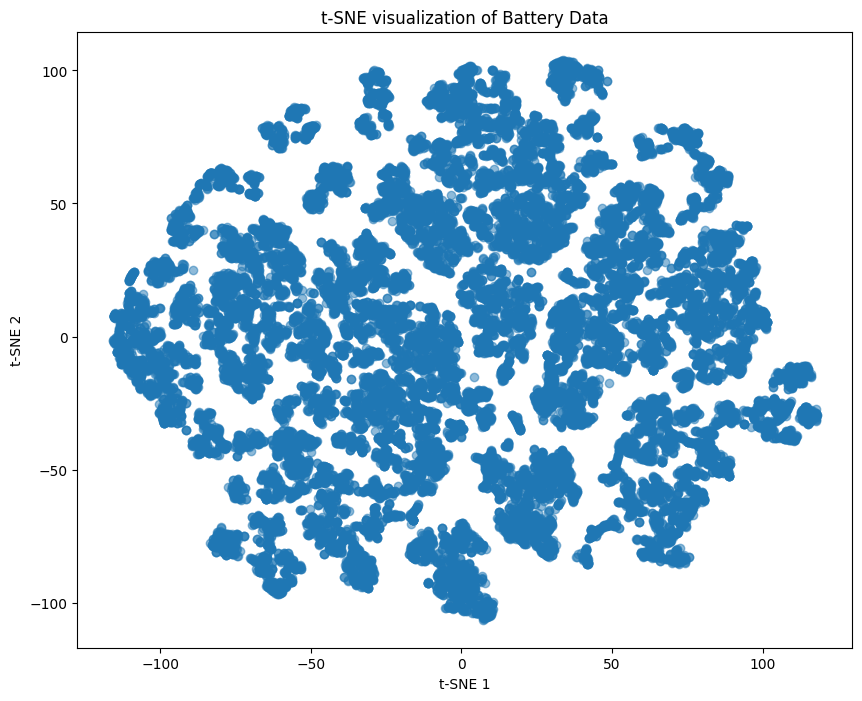

In [ ]:
# t-SNE

# Selecting important feature subsets
features = training_data.select_dtypes(include=[np.number])

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
print(features)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled= np.nan_to_num(features_scaled,nan=0)
print((features_scaled))
features_scaled_array=np.array(features_scaled)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)

tsne_results = tsne.fit_transform(features_scaled_array)

# Plot of t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of Battery Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()



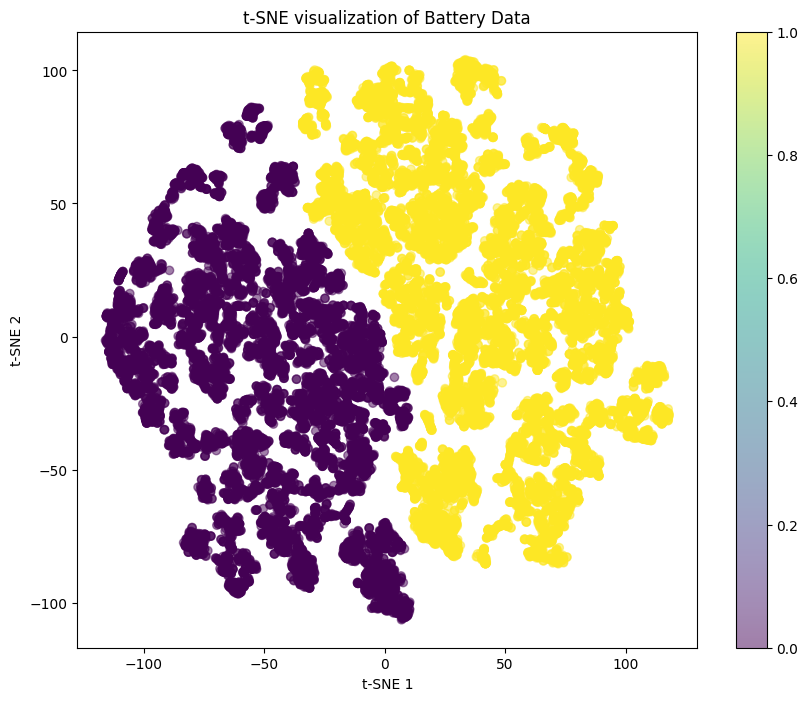

In [ ]:
# t- SNE  for normal operation
normal_operation_labels = data['Normal Operation'].values

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

# Plot the results of t-SNE with labels
plt.figure(figsize=(10, 8))

# Scatter plot, coloring points by the 'Normal Operation' label
# Here, 'c=normal_operation_labels' is used to color the points
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=normal_operation_labels, alpha=0.5, cmap='viridis')

# Add a color bar to the side to indicate the label
plt.colorbar()

plt.title('t-SNE visualization of Battery Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


## Initial Model Building and baseline establishment

Epoch 1/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5375 - loss: 0.6906 - val_accuracy: 0.5554 - val_loss: 0.6875
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5505 - loss: 0.6883 - val_accuracy: 0.5554 - val_loss: 0.6882
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5455 - loss: 0.6893 - val_accuracy: 0.5554 - val_loss: 0.6877
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5435 - loss: 0.6894 - val_accuracy: 0.5554 - val_loss: 0.6874
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5444 - loss: 0.6893 - val_accuracy: 0.5554 - val_loss: 0.6874
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5532 - loss: 0.6875 - val_accuracy: 0.5554 - val_loss: 0.6882
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5459 - loss: 0.6892 - val_accuracy: 0.5554 - val_loss: 0.6877
Epoch 8/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5459 - loss: 0.6890 - val_accu

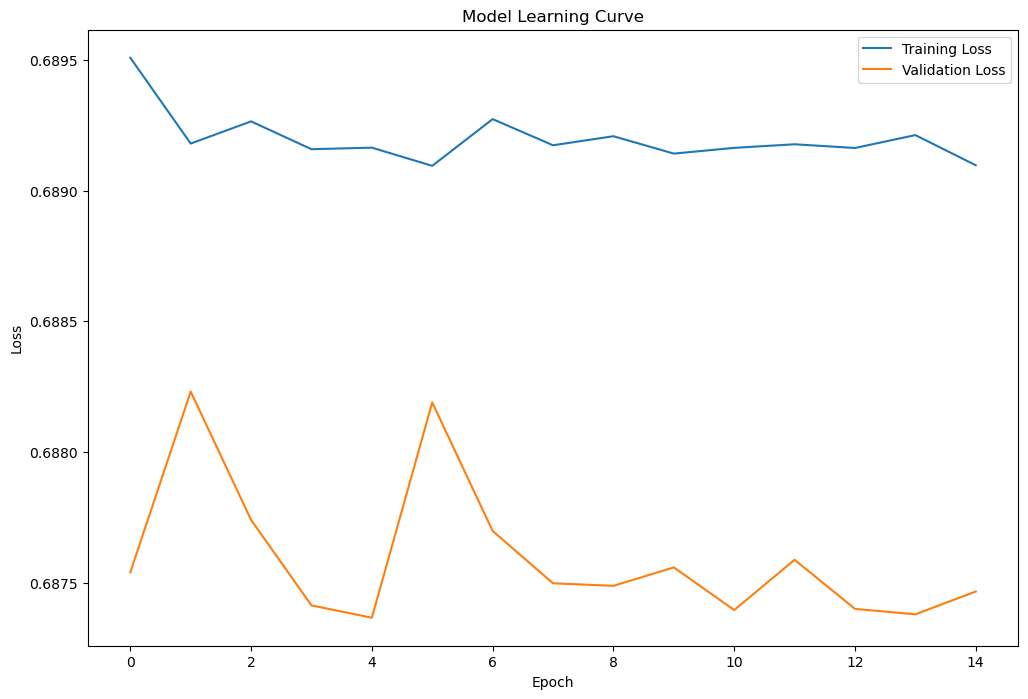

In [ ]:
"""#### DO NOT RUN THIS CODE ####


#Neural network model1 - This model failed. It was built on certain assumptions about the nature of the data
#Just a part of the learning process for real world data

# Separating the features and target
X = features
y = data['Normal Operation']

# Training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network architecture
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Training the model with early stopping
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=50,
    callbacks=[early_stopping]
)

# Model evaluation
scores = model.evaluate(X_test_scaled, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Learning curves
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
"""

### RE-BUILDING THE MODEL


In [ ]:
# Loading the datasets afresh
soc_data = pd.read_excel('soc_delta_values jan feb Training.xlsx')
battery_occurrences = pd.read_excel('Critically low battery occurences jan feb training.xlsx')

# Data structure
soc_data_head = soc_data.head()
battery_occurrences_head = battery_occurrences.head()

(soc_data_head, battery_occurrences_head)

data = soc_data.copy()


In [ ]:
data.sort_values(by=['carrierID', 'event_timestamp_EST'], inplace=True)

# Percentage drop in SoC over a 15-day rolling window
data['percent_drop_soc'] = data.groupby('carrierID')['soc'].transform(lambda x: np.where(x.shift(periods=15*24) == 0, 0, (x - x.shift(periods=15*24)) / x.shift(periods=15*24) * 100))

# Filtering out any possible infinite values
data['percent_drop_soc'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['percent_drop_soc'].fillna(0, inplace=True)

# Average percentage drop across all data
average_percent_drop = data['percent_drop_soc'].mean()

print(f"The average percentage drop in SoC over the rolling period is {average_percent_drop:.2f}%.")

The average percentage drop in SoC over the rolling period is 8.20%.


In [ ]:
# DEFINING WHAT CRITICAL CONDITION IS BASED ON SOC DROPS - BATTERY ABOUT TO FAIL

soc_data_clean = soc_data.drop(columns=[col for col in soc_data.columns if 'Unnamed' in col or 'Combined_Column' in col])

# Feature Engineering: Binary feature for critical SoC level
critical_threshold = 20  # critical SoC level of 20%
soc_data_clean['critical_soc'] = (soc_data_clean['soc'] < critical_threshold).astype(int)

# Rate of SoC decline over a 24-hour rolling window
soc_data_clean['soc_decline_rate'] = soc_data_clean.groupby('carrierID')['soc'].rolling(window=24).apply(lambda x: x.iloc[-1] - x.iloc[0]).reset_index(level=0, drop=True)

# Creating a binary target variable where 1 indicates a rapid drop in SoC (defined as a drop of 10% or more within 24 hours)
rapid_drop_threshold = 10  # rapid drop threshold of 10%
soc_data_clean['target_rapid_drop'] = (soc_data_clean['soc_decline_rate'] <= -rapid_drop_threshold).astype(int)

# Selecting the numeric features to be normalized
numeric_features = ['soc', 'soc_decline_rate']
scaler = StandardScaler()

# Adding normalized features back into the DataFrame
soc_data_clean[numeric_features] = scaler.fit_transform(soc_data_clean[numeric_features])

# Check the first few rows of the DataFrame to confirm changes
soc_data_clean[['carrierID', 'event_timestamp_EST', 'soc', 'critical_soc', 'soc_decline_rate', 'target_rapid_drop']].head()


carrierID     event_timestamp_EST       soc  critical_soc  soc_decline_rate  \
0   BOX-002 2024-02-02 07:15:42.360 -2.102695             0               NaN   
1   BOX-002 2024-02-02 07:17:28.706 -1.937770             0               NaN   
2   BOX-002 2024-02-02 07:18:58.694  0.481129             0               NaN   
3   BOX-002 2024-02-02 07:20:17.904  0.701029             0               NaN   
4   BOX-002 2024-02-02 07:21:35.711  0.041329             0               NaN   

   target_rapid_drop  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [ ]:
# Fill NaN values in 'soc_decline_rate' with 0
soc_data_clean['soc_decline_rate'].fillna(0, inplace=True)

In [ ]:
#Grid search to learn the best hyperparameters

# Fill NaN values in 'soc_decline_rate' with 0
soc_data_clean['soc_decline_rate'].fillna(0, inplace=True)

# Split the data into features and target
X = soc_data_clean[['soc', 'critical_soc', 'soc_decline_rate']]  # Features
y = soc_data_clean['target_rapid_drop']  # Target variable

# Training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the MLP model
# Initializing the MLPClassifier with a single hidden layer of 100 neurons
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Define a grid of hyperparameters to search over
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# GridSearchCV with the MLPClassifier and the parameter grid
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters and Best MLP model from grid search
best_params = grid_search.best_params_
best_mlp = grid_search.best_estimator_

(best_params, best_mlp)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


({'activation': 'tanh',
  'alpha': 0.0001,
  'hidden_layer_sizes': (50,),
  'learning_rate_init': 0.001,
  'solver': 'adam'},
 MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=1000,
               random_state=42))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3728
           1       1.00      1.00      1.00      1531

    accuracy                           1.00      5259
   macro avg       1.00      1.00      1.00      5259
weighted avg       1.00      1.00      1.00      5259

Confusion Matrix:
[[3728    0]
 [   0 1531]]


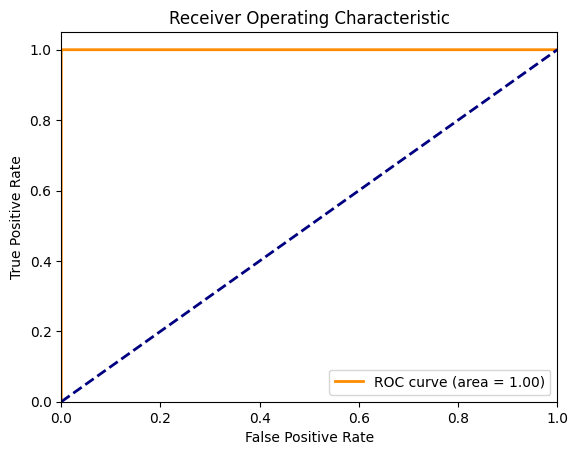

In [ ]:
# Making predictions with the best model
y_pred = best_mlp.predict(X_test)
y_pred_proba = best_mlp.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Classification report for precision, recall, f1-score, and accuracy
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot of ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Remaking teh soc decline rate over a 15 day period for the model
readings_per_day = 24
window_size = readings_per_day * 15  # Window size for 15 days

# Rate of SoC decline over a 15-day rolling window
soc_data_clean['soc_decline_rate_15d'] = soc_data_clean.groupby('carrierID')['soc'].rolling(window=window_size).apply(lambda x: x.iloc[-1] - x.iloc[0]).reset_index(level=0, drop=True)

# Normalizing the 'soc_decline_rate_15d' feature
soc_data_clean['soc_decline_rate_15d'] = scaler.fit_transform(soc_data_clean[['soc_decline_rate_15d']])

# Fill any NaN values that arise from the rolling operation
soc_data_clean['soc_decline_rate_15d'].fillna(0, inplace=True)

# Check the first few rows of the DataFrame to confirm changes
soc_data_clean[['carrierID', 'event_timestamp_EST', 'soc', 'critical_soc', 'soc_decline_rate_15d']].head()


carrierID     event_timestamp_EST       soc  critical_soc  \
0   BOX-002 2024-02-02 07:15:42.360 -2.102695             0   
1   BOX-002 2024-02-02 07:17:28.706 -1.937770             0   
2   BOX-002 2024-02-02 07:18:58.694  0.481129             0   
3   BOX-002 2024-02-02 07:20:17.904  0.701029             0   
4   BOX-002 2024-02-02 07:21:35.711  0.041329             0   

   soc_decline_rate_15d  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [ ]:

# Proceeding with the model training


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3728
           1       0.65      0.51      0.57      1531

    accuracy                           0.78      5259
   macro avg       0.73      0.70      0.71      5259
weighted avg       0.77      0.78      0.77      5259

Confusion Matrix:
[[3309  419]
 [ 749  782]]


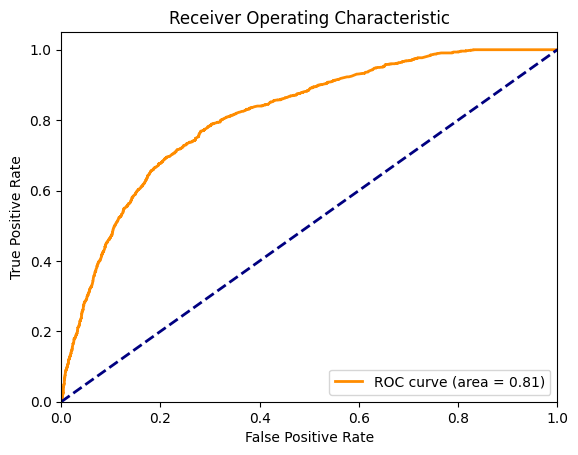

In [ ]:
# Select the features to be included in the model
features = ['soc', 'soc_decline_rate_15d']
X = soc_data_clean[features]

# Assuming 'charging_state' is the new feature column and it's already in binary form
soc_data_clean['Charging'] = soc_data_clean['Charging']

# Select the features to be included in the model, now including 'charging_state'
features = ['soc', 'soc_decline_rate_15d', 'Charging']
X = soc_data_clean[features]
y = soc_data_clean['target_rapid_drop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPClassifier(
    activation='tanh',
    alpha=0.0001,
    hidden_layer_sizes=(50,),
    learning_rate_init=0.001,
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)[:, 1]  # Probabilities for the positive class


# Classification report for precision, recall, f1-score, and accuracy
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Main models

### MLP

In [ ]:
# Removing carrier ID as a feature
if 'carrierID' in X:
    X = X.drop('carrierID', axis=1)

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Epoch 1/100
345/345 [==============================] - 4s 5ms/step - loss: 0.7885 - accuracy: 0.6323 - val_loss: 0.5571 - val_accuracy: 0.7514
Epoch 2/100
345/345 [==============================] - 1s 4ms/step - loss: 0.6886 - accuracy: 0.6823 - val_loss: 0.5530 - val_accuracy: 0.7519
Epoch 3/100
345/345 [==============================] - 1s 4ms/step - loss: 0.6463 - accuracy: 0.7020 - val_loss: 0.5332 - val_accuracy: 0.7614
Epoch 4/100
345/345 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.7142 - val_loss: 0.5289 - val_accuracy: 0.7676
Epoch 5/100
345/345 [==============================] - 1s 4ms/step - loss: 0.5869 - accuracy: 0.7309 - val_loss: 0.5225 - val_accuracy: 0.7709
Epoch 6/100
345/345 [==============================] - 1s 4ms/step - loss: 0.5711 - accuracy: 0.7408 - val_loss: 0.5211 - val_accuracy: 0.7719
Epoch 7/100
345/345 [==============================] - 2s 5ms/step - loss: 0.5530 - accuracy: 0.7515 - val_loss: 0.5160 - val_accuracy: 0.7733

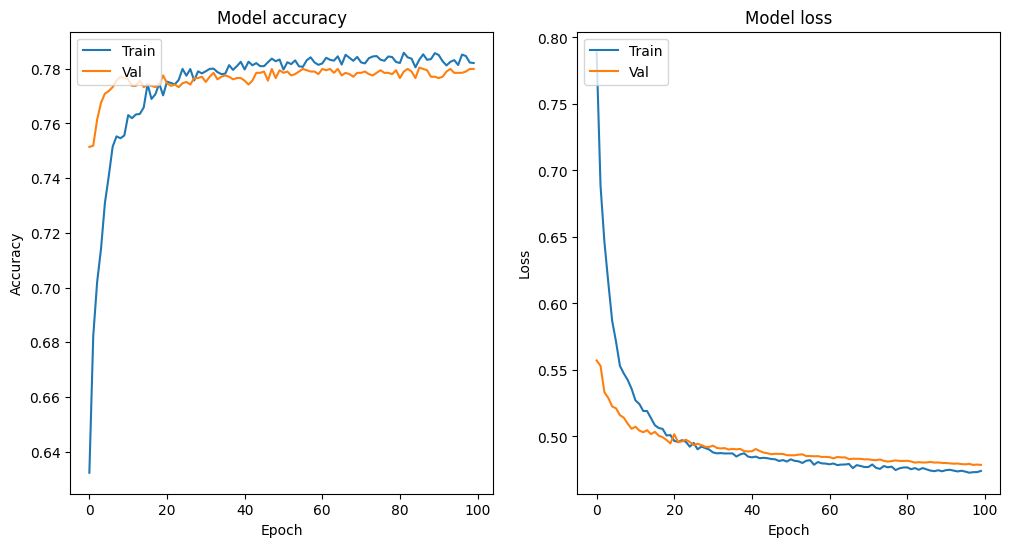

In [ ]:
# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(120, activation='tanh', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(60, activation='tanh', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Configuring the optimizer with a custom learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model with early stopping
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=55,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [ ]:
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Flatten y_pred_binary to convert it from 2D to 1D if necessary
y_pred_binary = y_pred_binary.flatten()

# Compute precision, recall, and F1 score
report = classification_report(y_test, y_pred_binary)
print(report)


165/165 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      3728
           1       0.64      0.55      0.59      1531

    accuracy                           0.78      5259
   macro avg       0.73      0.71      0.72      5259
weighted avg       0.77      0.78      0.77      5259



In [ ]:
### Random forest model

# Features and target variable
#features = ['soc', 'soc_decline_rate_15d', 'Charging']
#X = soc_data_clean[features]
#y = soc_data_clean['target_rapid_drop']

# Splitting the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Random Forest Model

In [35]:
# Training the Random Forest Model

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Model training
rf_model.fit(X_train, y_train)

# Predicting the test set results
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Model evaluation
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3728
           1       0.58      0.49      0.53      1531

    accuracy                           0.75      5259
   macro avg       0.69      0.67      0.68      5259
weighted avg       0.74      0.75      0.74      5259

Accuracy: 0.749762312226659
ROC AUC Score: 0.7692301694872492


### Gradient Boosting Machine (GBM)

In [36]:
### Gradient boosting machine - XAI

# Initialize the GBM classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Predicting the test set results
y_pred_gbm = gbm_model.predict(X_test)
y_pred_proba_gbm = gbm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Gradient Boosting Machine Classifier Report:")
print(classification_report(y_test, y_pred_gbm))
print("Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_gbm))


Gradient Boosting Machine Classifier Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3728
           1       0.64      0.53      0.58      1531

    accuracy                           0.78      5259
   macro avg       0.73      0.70      0.71      5259
weighted avg       0.77      0.78      0.77      5259

Accuracy: 0.7769537934968626
ROC AUC Score: 0.8127070058560845


## Implementing Explainable AI (XAI) - Feature importance and LIME

In [ ]:
nonsuspect_carrier_ids = ['BOX-012', 'BOX-015', 'BOX-016', 'BOX-019', 'BOX-032', ​

               'CAB-028', 'CAB-038', 'CAB-098', 'IP-001']

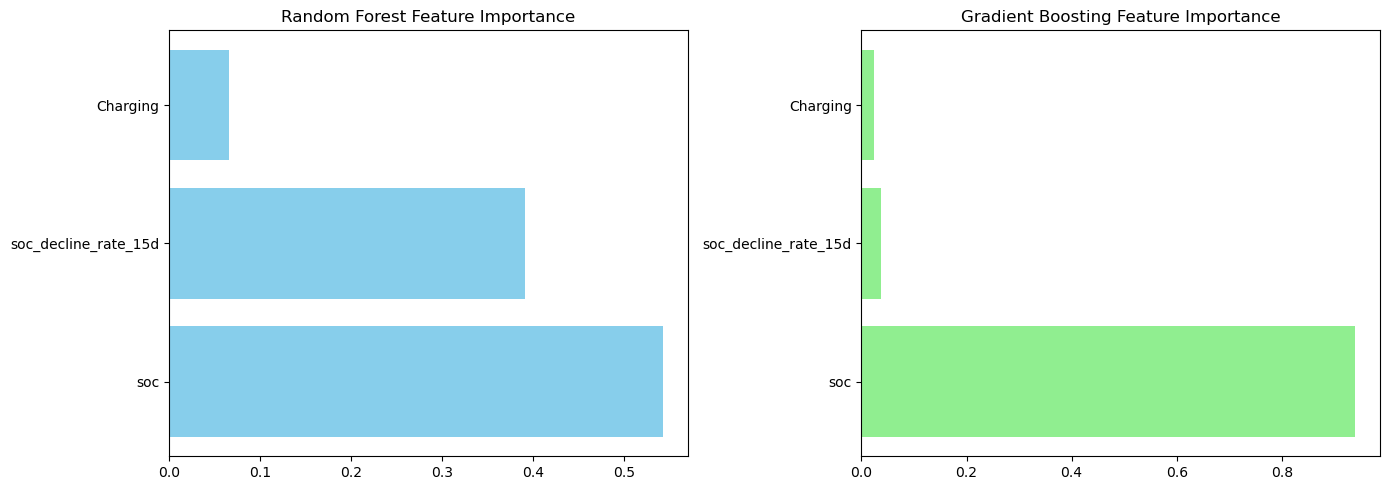

In [ ]:
# Feature importance
# Random Forest Feature Importance
rf_importances = rf_model.feature_importances_
gbm_importances = gbm_model.feature_importances_

# Creating plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].barh(features, rf_importances, color='skyblue')
ax[0].set_title('Random Forest Feature Importance')

ax[1].barh(features, gbm_importances, color='lightgreen')
ax[1].set_title('Gradient Boosting Feature Importance')

plt.tight_layout()
plt.show()


### Extracting the predicted likely battery failures from the model.

In [ ]:
# Make sure 'carrierID' is saved before you transform or scale your features
carrier_ids = soc_data_clean['carrierID']  # Copying carrier IDs before any manipulation

# Splitting data, ensuring that all parts are split in the same operation to maintain alignment
X = soc_data_clean.drop(['carrierID', 'target_rapid_drop'], axis=1)  # Assuming 'target_rapid_drop' is your target variable
y = soc_data_clean['target_rapid_drop']
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, carrier_ids, test_size=0.2, random_state=42)

# Immediately reset indices to avoid any future misalignment
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
ids_test = ids_test.reset_index(drop=True)


# Assuming the scaler is fitted with X_train like this:
scaler = StandardScaler()
X_train = X_train[['soc', 'soc_decline_rate_15d', 'Charging']]  # Ensure only these columns are included
X_train_scaled = scaler.fit_transform(X_train)

# Ensure X_test includes exactly the same columns in the same order:
X_test = X_test[['soc', 'soc_decline_rate_15d', 'Charging']]
# Apply the scaling
X_test_scaled = scaler.transform(X_test)

# Making predictions
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.flatten()  # Ensuring it's a 1D array for DataFrame use


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
#Creating the host dataframe

# Resetting y_test index if not already done
y_test = y_test.reset_index(drop=True)

# Creating DataFrame to analyze predictions
results_df = pd.DataFrame({
    'carrierID': ids_test,  # Ensure ids_test was captured correctly
    'Predicted_Failure': y_pred,
    'Actual_Failure': y_test
})

# Print to check output
print(results_df.head())


  carrierID  Predicted_Failure  Actual_Failure
0    IP-005           0.176279               0
1   BOX-039           0.035114               0
2   CAB-025           0.037393               0
3   BOX-015           0.405367               1
4   BOX-032           0.064097               1


In [ ]:
# Calculating Total Predicted Failures per Carrier ID and their respective prediction accuracy

# Summing the predicted failures for each carrier ID
predicted_failures_per_carrier = results_df.groupby('carrierID')['Predicted_Failure'].sum()

print("Total predicted failures for each Carrier ID:")
print(predicted_failures_per_carrier)

# Binarize predictions based on a threshold
threshold = 0.5  # Adjust this threshold based on your model's scoring
results_df['Predicted_Failure_Binary'] = (results_df['Predicted_Failure'] >= threshold).astype(int)

# Calculate accuracy per carrier ID
accuracy_per_carrier = results_df.groupby('carrierID').apply(
    lambda x: (x['Predicted_Failure_Binary'] == x['Actual_Failure']).mean()
)

print("Accuracy per Carrier ID:")
print(accuracy_per_carrier)

# Overall accuracy
overall_accuracy = (results_df['Predicted_Failure_Binary'] == results_df['Actual_Failure']).mean()
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Accuracy Results
accuracy_df = accuracy_per_carrier.reset_index()
accuracy_df.columns = ['CarrierID', 'Accuracy']

Total predicted failures for each Carrier ID:
carrierID
BOX-002     89.119766
BOX-006    170.477509
BOX-012     92.626663
BOX-015     65.867744
BOX-016     31.705757
BOX-019     63.889015
BOX-032     49.768673
BOX-039     52.846565
BOX-040    124.769386
CAB-025    126.123024
CAB-028     68.216255
CAB-038     32.092495
CAB-072     78.802658
CAB-080     38.983349
CAB-098     83.035141
CAB-119    225.726334
IP-001      27.352922
IP-005      55.907112
Name: Predicted_Failure, dtype: float32
Accuracy per Carrier ID:
carrierID
BOX-002    0.759036
BOX-006    0.796954
BOX-012    0.830028
BOX-015    0.786232
BOX-016    0.768041
BOX-019    0.793722
BOX-032    0.842795
BOX-039    0.785441
BOX-040    0.782500
CAB-025    0.748077
CAB-028    0.817427
CAB-038    0.804124
CAB-072    0.741036
CAB-080    0.723404
CAB-098    0.759091
CAB-119    0.708661
IP-001     0.784615
IP-005     0.723164
dtype: float64
Overall Accuracy: 0.77


### LIME explanation for suspected fail or no fail batteries

In [37]:
## Lime for XAI

# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Fail', 'Fail'],
    mode='classification'
)

# Explaining an individual prediction from the test set, e.g., the first instance(IP-005 - Which did not fail)
i = 0
exp = explainer.explain_instance(X_test.iloc[i], rf_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
## Lime for XAI 5255th instance (CAB-119 which actually failed)

# Explaining an individual prediction from the test set, e.g., 5255th instance (CAB-119 which actually failed)
i = 5255
exp = explainer.explain_instance(X_test.iloc[i], rf_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)


C:\Users\tosin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Decision tree path

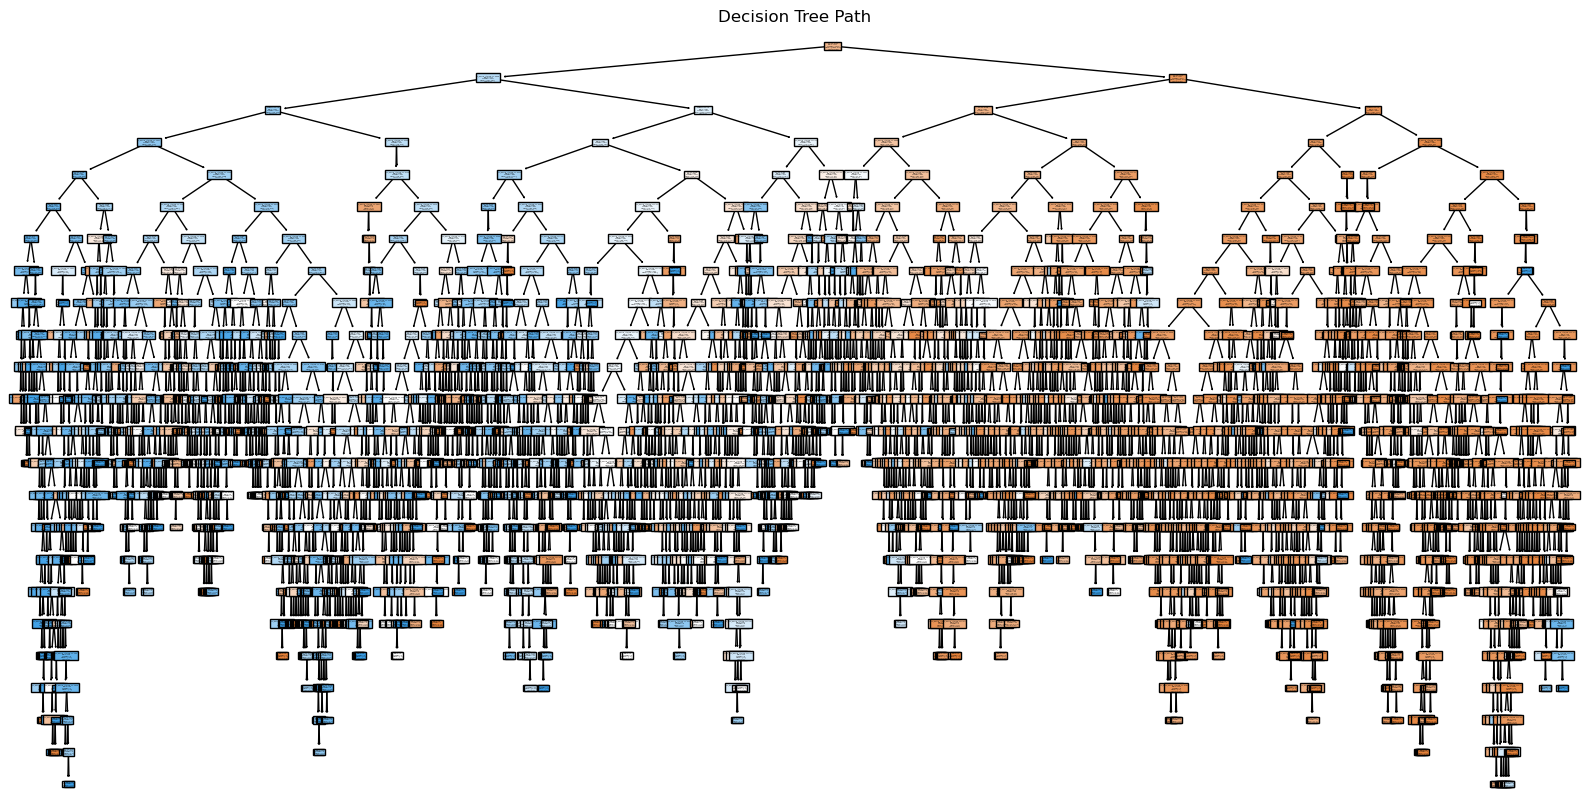

In [ ]:
### DECISION PLOTS FOR RF

# Assuming 'model' is a tree-based model like a DecisionTreeClassifier or one tree from a RandomForest
# Here, using the first tree from a RandomForest model as an example
tree = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=['No Fail', 'Fail'])
plt.title('Decision Tree Path')
plt.show()
